# Problem set 1 - Thomas Vandal

In [1]:
# all imports for the problem set
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.integrate import quad

import integrals as integ

## Problem 1
Numerical derivatives with four points to evaluate ($x \pm \delta$, $x \pm 2\delta$).

### Part (a)
Find an estimate of the first derivative at x.

First, let's Taylor expand $f$ at the points mentionned above:
$$
f(x \pm \delta) \approx f(x) \pm f'(x)\delta + \frac{f''(x)\delta^2}{2} \pm \frac{f'''(x)\delta^3}{6} + \frac{f^{(4)}(x)\delta^4}{24} \pm \frac{f^{(5)}(x)\delta^5}{120},
$$
$$
f(x \pm 2\delta) \approx f(x) \pm 2 f'(x)\delta + \frac{4 f''(x)\delta^2}{2} \pm \frac{8 f'''(x)\delta^3}{6} + \frac{16 f^{(4)}(x)\delta^4}{24} \pm \frac{32 f^{(5)}(x)\delta^5}{120}.
$$
We then subtract the superior and inferior point for each set, as we would do in a two-sided derivative. This gives us
$$
f(x + \delta) - f(x - \delta) \approx 2 f'(x)\delta + \frac{f'''(x)\delta^3}{3} + \frac{f^{(5)}(x)\delta^5}{60},
$$
and
$$
f(x + 2\delta) - f(x - 2\delta) \approx 4 f'(x)\delta + \frac{8 f'''(x)\delta^3}{3} + \frac{f^{(5)}(x)\delta^5}{60}.
$$
We can now take a linear combination of these two equations to cancel the $\delta^3$ terms, resulting in
$$
8\left[f(x + \delta) - f(x - \delta)\right] - \left[f(x + 2\delta) - f(x - 2\delta)\right] \approx 12\delta f'(x) - \frac{2}{5}\delta^5 f^{(5)}(x),
$$
which we can solve for f'(x) to find
$$
f'(x) \approx \frac{8 f(x + \delta) - 8 f(x - \delta) - f(x + 2\delta) + f(x - 2\delta)}{12\delta} + \frac{\delta^4}{30}f^{(5)}(x).
$$
The $\delta^4$ term is the leading term of the truncating error, $e_t$, coming from the series approximation, so our final estimation of the derivative at x is
$$
f'(x) \approx \frac{8 f(x + \delta) - 8 f(x - \delta) - f(x + 2\delta) + f(x - 2\delta)}{12\delta}.
$$

### Part (b)
Find the optimal value of $\delta$. Show that this estimate is at least roughly correct for $f(x)=\exp{x}$ and $f(x)=\exp{0.01 x}$.

We saw the truncation error $e_t$ in (a), but we should also account for the roundoff error, $e_r$. In general, the numerical representation of a function evaluation can be given by $\bar{f}(x) = f(x)(1+g_0\epsilon)$ where $g_0$ is a random number of order unity and $\epsilon$ is the machine precision ($~10^{-7}$ for single precision, $~10^{-16}$ for double). Using this, we get
$$
\bar{f}'(x) = \frac{8 \bar{f}(x + \delta) - 8 \bar{f}(x - \delta) - \bar{f}(x + 2\delta) + \bar{f}(x - 2\delta)}{12\delta} + \frac{\delta^4}{30}f^{(5)}(x),
$$
or equivalently
$$
\bar{f}'(x) = \frac{8 (1+g_{1,+}\epsilon)f(x + \delta) - 8 (1+g_{1,-}\epsilon)f(x - \delta) - (1+g_{2,+}\epsilon)f(x + 2\delta) + (1+g_{2,-}\epsilon)f(x - 2\delta)}{12\delta} + \frac{\delta^4}{30}f^{(5)}(x).
$$
The terms with $\epsilon$ are errors, so we take the leading terms as we did in class, approximate the $g_{i,\pm}$'s as 1 and obtain (in absolute value)
$$
\bar{f}'(x) = \frac{8 f(x + \delta) - 8 f(x - \delta) - f(x + 2\delta) + f(x - 2\delta)}{12\delta} + \frac{\epsilon}{\delta}\left|{\frac{18}{12}}f(x)\right| + \frac{\delta^4}{30}f^{(5)}(x),
$$
so our total error is 
$$
E = \left|\bar{f}'(x)-f(x)\right| = e_r + e_t = \frac{3\epsilon }{2\delta}\left|f(x)\right| + \frac{\delta^4}{30}\left|f^{(5)}(x)\right|.
$$
We now need to find the value of $\delta$ that minimizes $E$. Differentiating $E$ w.r.t. $\delta$ and equating to $0$, we find
$$
\delta = \left(\frac{45 f(x)}{4 f^{(5)}}\epsilon\right)^{(1/5)},
$$
which is our optimal $\delta$ to minimize the error.

We will now test this optimal $\delta$ prediction.

In [2]:
"""
Test for the optimal delta, question 1b of problem set 1.
"""
import numpy as np
import matplotlib.pyplot as plt


def check_delta(x, a, delta_arr=np.logspace(-15, 1, num=50), eps=1e-16,
                plotfile=None):
    """ Script to verify delta optimization

        Test the equations derived above on exponential function.
        This function is just a script allowing to change
        the test parameters easily.

        Args:
            x: where we evaluate the derivative
            a: coefficient multiplying x in the exponential
            delta_arr: values of delta where the equations are tested
            eps: machine precision
                 (python floats have double precision so default=1e-16)

        Prints a short report and produces a plot of E vs delta.
    """
    # Function depending on the parameters of check_delta
    def diff(func, x, delta):
        """Five point differentiator
        Args:
            func: function to differentiate
            x: value at which we take the derivative
            delta: step size

        returns:
            deriv: first derivative of func at x
        """
        deriv = ((8.0*func(x+delta)
                  - 8.0*func(x-delta)
                  - func(x+2.0*delta)
                  + func(x-2.0*delta)) / (12.0*delta))

        return deriv

    def optdelta(func, funcd5, x, eps=eps):
        """Optimal step size for five point differentiator
        Args:
            func: function to differentiate
            funcd5: fifth derivative of func
            x: value where we take the derivative
            eps: machine precision (default: 1e-16, approx double precision)
        Returns:
            delta: best step size to choose to derive func at x
        """
        delta = (45.0 * func(x) * eps / (4.0*funcd5(x)))**0.2

        return delta

    def exp(x, a=a):
        """Exponential function
        Args:
            x: values where we evaluate the function
            a: coefficient mulitplying x in exp
        Returns:
            exp(a*x)
        """
        return np.exp(a*x)

    def expdiff(x, a=a, n=5):
        """Nth derivative of exp(a*x)
        Args:
            x: values where we evaluate the function
            a: coefficient mulitplying x in exp
            n: order of the derivative to be returned
        Returns:
            a**n * exp(a*n)
        """
        return a**n * np.exp(a*x)

    # evaluate error and delta prediction
    deriv_arr = diff(exp, x, delta_arr)
    deriv_true = expdiff(x, n=1)
    err_arr = np.abs(deriv_arr - deriv_true)
    delta_pred = optdelta(exp, expdiff, x)

    # print some info
    print("Derivative of exp({} * x) at x={}".format(a, x))
    print("  Predicted delta:", delta_pred)
    print("  Delta giving minimal error:", delta_arr[np.argmin(err_arr)])
    print()

    plt.plot(delta_arr, err_arr, 'k.', label=r"Calculated error")
    plt.axvline(delta_pred, linestyle='--', label=r"Predicted $\delta$")
    plt.xlabel(r"$\delta$", fontsize=14)
    plt.ylabel(r"$E$", fontsize=14)
    plt.title(r"Error vs. step size", fontsize=18)
    plt.tick_params(labelsize=12)
    plt.xscale("log")
    plt.yscale("log")
    if plotfile is not None:
        plt.savefig(plotfile)
        plt.close()
    else:
        plt.show()

Derivative of exp(1.0 * x) at x=0.0
  Predicted delta: 0.0010238362555396092
  Delta giving minimal error: 0.0005689866029018281



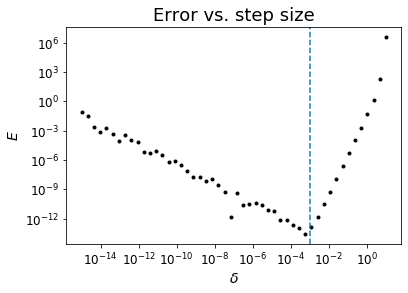

Derivative of exp(0.01 * x) at x=0.0
  Predicted delta: 0.10238362555396095
  Delta giving minimal error: 0.10985411419875572



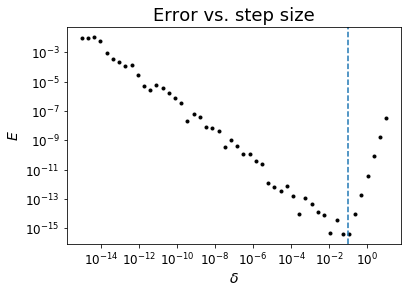

In [3]:
# test at x=0
check_delta(0.0, 1.0, plotfile=None)
check_delta(0.0, 0.01, plotfile=None)

Derivative of exp(1.0 * x) at x=100.0
  Predicted delta: 0.0010238362555396092
  Delta giving minimal error: 0.0025595479226995332



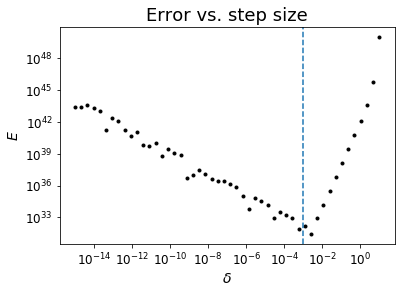

Derivative of exp(0.01 * x) at x=100.0
  Predicted delta: 0.10238362555396095
  Delta giving minimal error: 0.05179474679231202



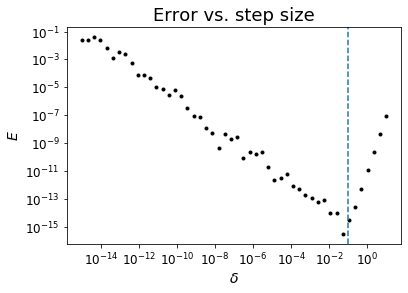

In [4]:
# test at x=100
check_delta(100.0, 1.0, plotfile=None)
check_delta(100.0, 0.01, plotfile=None)

By performing the same tests at $x=0,100$, and $a=1, 0.01$, we see that the predicted $\delta$'s are reasonably close to the value found in the test. Some $\delta$'s are off by a factor of two, which could be due to the truncation error, but the answers are still have the same order of magnitude, which is reasonably close.

## Problem 2
We use a scipy cubic spline to interpolate. To get a rough estimate of the error, we use the provided derivative, the spline calculated derivative and the following:
$$
f'(x) \approx \frac{\Delta f}{\Delta x}.
$$
We then subtract the two derivatives (table and spline) to get
$$
\left| f_s - f_t \right| = \left| \left(f_s' - f_t'\right)\left(x-x_0\right) \right|
$$
for a given x and its closest tabulated value $x_0$ (the $f_0$'s have cancelled each other cancel in the equation above.

Mean estimated error: 1.4633431888467847e-05


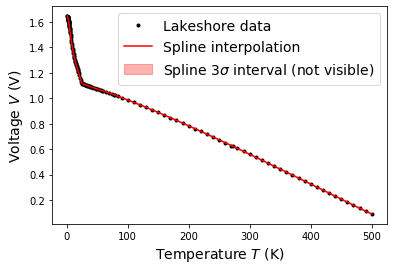

In [5]:
# where plot will be saved
plotfile = None  # "q2.png"


# the routine asked for in the problem set
def interp(spln, xnew, xknown=None, deriv_true=None):
    """Interpolate using a spline (with error estimate)

    Interpolation is performed with scipy.interpolate.splev.

    The (rough) estimate of the error is obtained by comparing linear
    extrapolations of the derivatives, since the only extra info we have about
    the tabulated values is the derivative, and the spline takes the exact
    value at knots.

    Args:
        spln (tuple): tuple with knots, coefficients, and order
                      (as returned by scipy.interpolate.splrep)
        xnew (array): x-values where we want to interpolate the function
                      represented by spln
        xknown (array): x values used to calculate spln (default: None)
        deriv_true (array): true derivative at known
    Returns:
        ynew (array): y-values of the interpolation
        err (array): estimated error at each y value
                       (returned only if known and deriv_true are given)
    """
    # evaluate the spline (ynew)
    ynew = interpolate.splev(xnew, spln)

    # evaluate error at each point if needed
    if xknown is not None and deriv_true is not None:
        # get first derivative of the spline at known x
        yp = interpolate.splev(xknown, spln, der=1)

        # get x, deriv, and yp at closest xknwon for each xnew
        iprox = []
        for k in range(len(xnew)):
            iprox.append(np.abs(xnew[k] - xknown).argmin())
        x_prox = xknown[iprox]     # known x
        deriv_prox = deriv_true[iprox]  # given true deriv
        yp_prox = yp[iprox]        # spline derivative

        # get rough estimate of the error. At given point x with closest known
        # point x0, f0:
        # f' \approx \delta f /\delta x
        # => abs(f_s' - f_t') =  abs((f_s - f0 - f_t + f_0)/(x-x0))
        # => abs(f_s - f_t) = abs((f_s' - f_t')/(x-x0))
        err = np.abs((yp_prox-deriv_prox)*(xnew-x_prox))

        return ynew, err

    return ynew


# load diode data (K, V, mV/K)
temp, volt, dvdt = np.loadtxt(
                "./lakeshore.txt").T
dvdt *= 1e-3  # adjust derivative

# use scipy to setup spline that we will use later
spln = interpolate.splrep(temp, volt)  # default is cubic (k=3, see docs)


# test an interpolation
xinter = np.linspace(temp.min(),
                     temp.max(),
                     num=10000)  # many pts to model dense region near 0
xinter = np.append(xinter, temp)
xinter = np.unique(xinter)
yinter, einter = interp(spln, xinter, xknown=temp, deriv_true=dvdt)

# mean estimated error (I get around 1e-5)
print("Mean estimated error: {}".format(np.mean(einter)))

# plot of the data along the interpolation
# Note: the error is not visible unless we zoom in
plt.plot(temp, volt, 'k.', label='Lakeshore data')
plt.plot(xinter, yinter, 'r', label='Spline interpolation')
plt.fill_between(xinter, yinter+3*einter, yinter-3*einter,
                 color='r', alpha=0.3,
                 label=r'Spline 3$\sigma$ interval (not visible)')
plt.xlabel('Temperature $T$ (K)', fontsize=14)
plt.ylabel('Voltage $V$ (V)', fontsize=14)
plt.legend(fontsize=14)
if plotfile is not None:
    plt.savefig(plotfile)
    plt.close()
else:
    plt.show()


## Problem 3
The efficent and "lazy" integrators for this problem are in the file integrals.py. Instead of directly using a linspace and calling the function eveytime, we can store the values and reuse them directly in a recursive method. Only two function evaluations per recursive call are needed, instead of 5 per call as above (or even 6 per call for some less efficient methods).

We see below that the error is reasonable, that we are relatively close to the analytical answer, and that our new integrator requires a bit less than half the calls, as expected.

In [6]:
"""
Tets the integrators from integrals.py
"""
import numpy as np

import integrals as integ

sig = 0.1  # used in f2 def, but needed later


def fun0(x):
    return np.exp(x)


def fun1(x):
    return 1.0/(1.0+x**2)


def fun2(x, sig=sig):
    return 1.0+np.exp(-0.5*x**2/(sig**2))


# From these evaluations, we see that both integrators give similar errors
# wrt the analytic integral. We see that we need about half the functions calls
# compared to the lazy integration method when we use the efficient
# (a bit less as we see when neval is high).
print("Integrating exp")
a, b = -1.0, 1.0
pred = np.exp(b) - np.exp(a)
f_lazy, myerr_lazy, neval_lazy = integ.lazy_integrate(fun0, a, b, 1e-3)
f_eff, myerr_eff, neval_eff = integ.eff_integrate(fun0, a, b, 1e-3)
print("  Lazy method: f, myerr, neval= {}, {}, {}. Err={}".format(f_lazy,
                                                                  myerr_lazy,
                                                                  neval_lazy,
                                                                  f_lazy-pred))
print("  Efficient method: f, myerr, neval= {}, {}, {}. Err={}".format(
                                                                  f_eff,
                                                                  myerr_eff,
                                                                  neval_eff,
                                                                  f_eff-pred))

print("Integrating fun1")
a, b = -1.0, 1.0
pred = np.arctan(b) - np.arctan(a)
f_lazy, myerr_lazy, neval_lazy = integ.lazy_integrate(fun1, a, b, 1e-4)
f_eff, myerr_eff, neval_eff = integ.eff_integrate(fun1, a, b, 1e-4)
print("  Lazy method: f, myerr, neval= {}, {}, {}. Err={}".format(f_lazy,
                                                                  myerr_lazy,
                                                                  neval_lazy,
                                                                  f_lazy-pred))
print("  Efficient method: f, myerr, neval= {}, {}, {}. Err={}".format(
                                                                  f_eff,
                                                                  myerr_eff,
                                                                  neval_eff,
                                                                  f_eff-pred))

print("Integrating fun2")
a, b = -5.0, 5.0
pred = (b-a) + np.sqrt(2*np.pi)*sig
f_lazy, myerr_lazy, neval_lazy = integ.lazy_integrate(fun2, a, b, 1e-4)
f_eff, myerr_eff, neval_eff = integ.eff_integrate(fun2, a, b, 1e-4)
print("  Lazy method: f, myerr, neval= {}, {}, {}. Err={}".format(f_lazy,
                                                                  myerr_lazy,
                                                                  neval_lazy,
                                                                  f_lazy-pred))
print("  Efficient method: f, myerr, neval= {}, {}, {}. Err={}".format(
                                                                  f_eff,
                                                                  myerr_eff,
                                                                  neval_eff,
                                                                  f_eff-pred))


Integrating exp
  Lazy method: f, myerr, neval= 2.350402717226764, 0.00023419190498064069, 25. Err=3.299391613253988e-07
  Efficient method: f, myerr, neval= 2.350402717226764, 0.00023419190498052966, 13. Err=3.299391613253988e-07
Integrating fun1
  Lazy method: f, myerr, neval= 1.5707963305712818, 2.357748463668874e-05, 75. Err=3.776385204545818e-09
  Efficient method: f, myerr, neval= 1.5707963305712815, 2.3577484636577717e-05, 33. Err=3.776384982501213e-09
Integrating fun2
  Lazy method: f, myerr, neval= 10.250662846829037, 3.532927117438911e-06, 335. Err=1.936593641005402e-08
  Efficient method: f, myerr, neval= 10.250662846829037, 3.5329271178552446e-06, 137. Err=1.936593641005402e-08


## Problem 4
For this problem, we need to integrate  the function
$$
f(u) = \frac{z - Ru}{(R^2 + z^2 - 2Rzu)^(3/2)}
$$
from -1 to 1. As we see below, there is a singularity in the integral when z=R and u=1. I edited the integrator from 3 so that it is compatible with arrays (multiple z at a time). I also had to edit it because it was not converging at the singularity. I used an exploration of the problemtic u's nbhd to find a close approximation (see the 3 while loops in integrals.py). This exploration method is not very elaborated and is probably not, well suited for all similar problems, but it works well here. The results are the same as those from scipy's quad.

/home/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


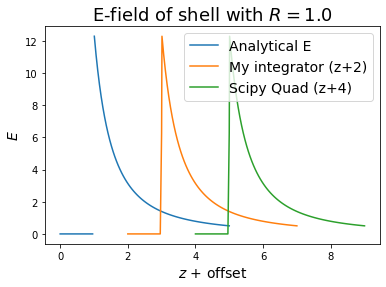

In [7]:
"""
Solution to question 4: integrating to get the E-field of  a spherical shell
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

import integrals as integ

# R value and z array
R = 1.0
zvals = np.linspace(1e-3, 5, num=100)  # z values >, < & == R
zvals = np.append(zvals, R)
zvals = np.unique(zvals)
plotfile = None  # "q4.png", where plot is saved


# setting up the problem
def fu(u, z=zvals, R=1.0):
    """Integrand for the E-field (see griffiths problem 2.7 for derivation)
    Args:
        u: values at which we evaluate f
        z: position on the z axis
        R: radius of the shell
    Returns
        f: function value at u
    """
    f = (z - R*u) / (R**2 + z**2 - 2*R*z*u)**(1.5)

    return f


def Efield(z, R=1.0):
    """Analytical soln for E-field along z axis
    Args:
        z: position on the z axis
        R: radius of the shell
    Returns:
        efield: E-field at z
    """
    try:
        efield = np.zeros(len(z))
    except TypeError:
        efield = np.zeros(1)

    # inside stays 0. assign others
    efield[z > R] = z[z > R]**(-2.0)
    efield[z == R] = np.nan * np.ones(len(z[z == R]))

    return efield


def quadloop(fun, a, b, zvals=zvals, args=()):
    """Integrate with quad at several z values
    """
    flist, elist = [], []
    for z in zvals:
        f, e = quad(lambda u: fu(u, z=z), a, b, args=args)
        flist.append(f)
        elist.append(e)

    return np.array(flist), np.array(elist)


# NOTE 1: I adapted the integrator from 3 so that it is compatible with arrays
#         to pass zvals as an argument to f directly

# NOTE 2: There is a singularity at u=1 when z=R. Scipy quad is not affected by
#         this, but our integrator was. I adjusted the integrator so that it
#         explores the nbhd of the u causing problem and that fixed it for this
#         case. However, I am not sure my implementation would be stable for
#         other similar situations (it might need a more extensive
#         exploration).


# Integrate fu to get E-field.
# The n*pi factors just result from the normalizations I neglected above.
# The warning we get comes from the first step of the exploration described
#   above.
a, b = -1, 1  # bounds on u
field_myint, myerr, neval = integ.eff_integrate(fu, a, b, 1e-7, maxcalls=1000)
field_myint *= 2*np.pi  # rescale to be consistent with Efield
field_quad, quaderr = quadloop(fu, a, b)
field_quad *= 2*np.pi
field_def = Efield(zvals) * 4*np.pi  # rescale to be consistent w/ integration
# Note: Efield not defined at R (I explicitely assigned to NaN)

# plotting with z offset to show the shapes
plt.plot(zvals, field_def, label="Analytical E")
plt.plot(zvals+2, field_myint, label="My integrator (z+2)")
plt.plot(zvals+4, field_quad, label="Scipy Quad (z+4)")
plt.xlabel("$z$ + offset", fontsize=14)
plt.ylabel("$E$", fontsize=14)
plt.title("E-field of shell with $R={}$".format(R), fontsize=18)
plt.legend(fontsize=14)
if plotfile is not None:
    plt.savefig(plotfile)
    plt.close()
else:
    plt.show()
